In [4]:
import pandas as pd
import os
from os import path
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import percentile
import datetime
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import classification_report_imbalanced
from scipy.sparse import csr_matrix

base_path = '/data/pixel-annot-export-v0.9/'
ann_path = path.join(base_path, 'pixel_df_list/')

ds_df_path = path.join(base_path, 'ds_df.msgpack')
ds_df = pd.read_msgpack(ds_df_path)

ion_df_path = path.join(base_path, 'ion_df.msgpack')
ion_df = pd.read_msgpack(ion_df_path)

formula_df_path = path.join(base_path, 'formula_df.msgpack')
formula_df = pd.read_msgpack(formula_df_path)

gs_path = '/data/katya/offsample_gs/GS.csv'
gs_df = pd.read_csv(gs_path)

sim_features_dir = '/data/katya/offsample_gs_vectors'

In [5]:
def biclustering(arr, n_clusters):
    clustering = SpectralCoclustering(n_clusters=n_clusters, mini_batch=False, n_jobs=-1, random_state=1).fit(arr)
    return clustering

In [6]:
# Remove hotspots from dataframe
def hotspot_removal(input_df, p):
    q = input_df.int.quantile(p)
    input_df.loc[input_df['int'] > q, 'int'] = q
    return input_df

In [7]:
def draw_image(ion_sub_df, max_x, max_y, hotspot = True, full = True):
    if hotspot: ion_sub_df = hotspot_removal(ion_sub_df, .99)
    
    arr = np.zeros([max_x+1, max_y+1])
    
    for _, row in ion_sub_df.groupby(['x','y']):
        if full: arr[row.x.values[0]][row.y.values[0]] = row.int.values[0]
        else: arr[row.x.values[0]][row.y.values[0]] = 1
        
    arr = np.rot90(arr, 1)
    plt.pcolormesh(arr,cmap='viridis')
    plt.axes().set_aspect('equal', 'datalim')
    plt.axes().axis('off')
    plt.show()

In [8]:
def draw_clusters(clusters, coord_x, coord_y):    
    img = pd.pivot(coord_y, coord_x, clusters).fillna(-1).values
    plt.pcolormesh(img,cmap='viridis')
    plt.axes().set_aspect('equal', 'datalim')
    plt.axes().axis('off')
    plt.show()

In [9]:
# Find border pixels
import cv2
from pylab import *

non_perim_tolerance = 5
out_frame_width = 1

def find_border_pixels(coord_df):
    max_x = coord_df['x'].max()
    max_y = coord_df['y'].max()
    
    min_x = coord_df['x'].min()
    min_y = coord_df['y'].min() 
       
    border_df = coord_df[(coord_df['x']==min_x) | (coord_df['y']==min_y)| (coord_df['x']==max_x) | (coord_df['y']==max_y)]    
    
    perim = 2*(max_x+1 + max_y+1) - 4
    
    # Check if the image is rectangular: 
    # the number of min and max pixels correspond to the length of the perimeter with tolerance non_perim_tolerance
    # If it's rectangular, return the perimeter with width out_frame_width
    if(abs(len(border_df.index.tolist()) - perim)<non_perim_tolerance):
        out_coord_df = border_df
    # For non-rectangular images, compute border
    else:
        arr = np.zeros((max_y+1, max_x+1), dtype = np.uint8)
        for (x,y), row in coord_df.groupby(['x','y']):
            arr[y][x] = 255
        im2, contours, hierarchy = cv2.findContours(arr,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)        
        
        out_coord_df = pd.DataFrame(columns=['x', 'y']) 
        for c in contours:
            c = c.reshape(c.shape[0], 2)
            res_df = pd.DataFrame(c, columns=['x', 'y']) 
            out_coord_df = out_coord_df.append(res_df)
        y_zero = np.where(~arr.any(axis=1))[0] 
        x_zero = np.where(~arr.any(axis=0))[0]
        x_exclude = (x_zero + 1).tolist() + (x_zero - 1).tolist()
        y_exclude = (y_zero + 1).tolist() + (y_zero - 1).tolist()
        out_coord_df = out_coord_df[(~out_coord_df['x'].isin(x_exclude)) & (~out_coord_df['y'].isin(y_exclude))]
        
    out_coord_df = out_coord_df.drop_duplicates()[['x', 'y']]
    out_coord_df['bord'] = True
    return out_coord_df

In [10]:
# Get ion indices from dataframe
def get_ion_ind_df(ds_rows):
    result = []
    for _, row in ds_rows.iterrows():
        ion_ind_list = ion_df[ion_df.formula == row.sumFormula][ion_df.adduct == row.adduct].index.tolist()
        if len(ion_ind_list) == 0:
            print('No ion in the dictionary: ', sf, adduct)
        else:
            ion_ind = int(ion_ind_list[0])
            result.append(ion_ind)
    return result

In [11]:
def find_clusters(pix_ion_matrix, coord_df):
    n_clusters = range(2,15)
    for n in n_clusters:
        clustering = biclustering(pix_ion_matrix, n)
        pixel_clusters = clustering.row_labels_
        coord_df['cluster'] = pixel_clusters
        
        unique, counts = np.unique(pixel_clusters, return_counts=True)
        w_counts = counts / pixel_clusters.shape[0]
        valid_clusters = []
        small_clusters = []
        
        for i in range(0, len(w_counts)):
            c = unique[i]
            w = w_counts[i]
            if w > 0.09:
                valid_clusters.append(c)
            else: 
                c_bord = coord_df[(coord_df.cluster==c) & (~coord_df['bord'].isnull())].shape[0]
                bord = coord_df[~coord_df['bord'].isnull()].shape[0]
                if c_bord/bord > 0.6:
                    valid_clusters.append(c)
                else: 
                    small_clusters.append(c)
        if len(valid_clusters) >= 2: break
    
    return (valid_clusters, small_clusters, coord_df, pixel_clusters, clustering)

In [12]:
import skimage
from skimage import measure

def cluster_classification(pixel_df, coord_df, ann_ions):  
    max_x = pixel_df['x'].max()
    max_y = pixel_df['y'].max()
            
    pixel_df = pixel_df.assign(p_ind = pixel_df.y.astype(np.int32) + (pixel_df.x.astype(np.int32) * (max_y + 1)))
    
    ions = pixel_df.ion_ind.unique().tolist()
    
    i_dict = dict(zip(ions, range(0, len(ions))))
    pixel_df['ion_ind'] = pixel_df['ion_ind'].map(i_dict.get)
    
    if(len(pixel_df.p_ind.unique())<pixel_df.p_ind.max()+1):
        p_dict = dict(zip(pixel_df.p_ind.unique().tolist(), range(0, len(pixel_df.p_ind.unique()))))
        pixel_df['p_ind'] = pixel_df['p_ind'].map(p_dict.get)
    
    pix_ion_matrix = csr_matrix((pixel_df.int.values, (pixel_df.p_ind.values, pixel_df.ion_ind.values))) 
    print('matrix generated', pix_ion_matrix.shape)
        
    (valid_clusters, small_clusters, coord_df, pixel_clusters, clustering) = find_clusters(pix_ion_matrix, coord_df)
    
    if len(small_clusters)>0:
        pix_ion_matrix.data = np.log10(pix_ion_matrix.data) + 10
        (valid_clusters, small_clusters, coord_df, pixel_clusters, clustering) = find_clusters(pix_ion_matrix, coord_df)
        
    noisy_clusters = False
    
    #CHECK NOISY CLUSTERS
    bi_pix_clusters = np.copy(pixel_clusters)
    bi_pix_clusters[bi_pix_clusters==valid_clusters[0]] = 1000
    bi_pix_clusters[bi_pix_clusters==valid_clusters[1]] = 2000
    bi_pix_clusters[bi_pix_clusters<=1000] = 0
    bi_pix_clusters[bi_pix_clusters==2000] = 1
    img = pd.pivot(coord_df.y.values, coord_df.x.values, bi_pix_clusters).fillna(0).values
    per = skimage.measure.perimeter(img)
    snr = per/coord_df.shape[0]
    print('SNR for clusters =', snr)
    if snr>0.22:
        bad_ions = filter_ions(pixel_df)
        filtered_pixel_df = pixel_df[pixel_df.ion_ind.isin(bad_ions)]
        pix_ion_matrix[filtered_pixel_df.p_ind.values, filtered_pixel_df.ion_ind.values] = 0.00000000001
        (valid_clusters, small_clusters, coord_df, pixel_clusters, clustering) = find_clusters(pix_ion_matrix, coord_df)
    
    draw_clusters(pixel_clusters, coord_df.x.values, coord_df.y.values)
    
    if len(valid_clusters)<2: print('BAD clusters')
    if len(valid_clusters)>2: print('MORE valid clusters', len(valid_clusters))
    
    print('clusters found, n =', len(valid_clusters+small_clusters))
    
    on_clusters = []
    off_clusters = []
    
    #large cluster classification
    c0_bord = coord_df[(coord_df.cluster==valid_clusters[0]) & (~coord_df['bord'].isnull())].shape[0]
    c1_bord = coord_df[(coord_df.cluster==valid_clusters[1]) & (~coord_df['bord'].isnull())].shape[0]
    if ds_name in swap_clusters:
        tmp = c0_bord
        c0_bord = c1_bord
        c1_bord = tmp
                
    if c0_bord > c1_bord: 
        off_clusters.append(valid_clusters[0])
        on_clusters.append(valid_clusters[1])
    else:
        on_clusters.append(valid_clusters[0])
        off_clusters.append(valid_clusters[1])
    
    #small cluster classification
    small_on_clusters = []
    small_off_clusters = []
    for c in small_clusters:
        c_bord = coord_df[(coord_df.cluster==c) & (~coord_df['bord'].isnull())].shape[0]
        c_full = coord_df[(coord_df.cluster==c)].shape[0]
        if c_full == 0: 
            small_on_clusters.append(c)
            continue
        bord = coord_df[~coord_df['bord'].isnull()].shape[0]
        if c_bord/bord > 0.1 or c_bord/c_full > 0.1: small_off_clusters.append(c)
        else: small_on_clusters.append(c)
        
    ann_ions = [i_dict[ion_ind] for ion_ind in ann_ions]
    ion_clusters = []
    for i in ann_ions:
        i_c = clustering.column_labels_[i]
        if i_c in off_clusters: ion_clusters.append(1)
        elif i_c in on_clusters: ion_clusters.append(0)
        elif i_c in small_off_clusters: ion_clusters.append(1)
        else: ion_clusters.append(0)
                                        
    return (True, ion_clusters)

In [13]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [14]:
def filter_ions(pixel_df):
    bad_ions = []
    for ion_ind, ion_rows in pixel_df.groupby('ion_ind'):
        snr = signaltonoise(ion_rows.int.values)
        if snr>=1: bad_ions.append(ion_ind)
        #else: draw_image(ion_rows, pixel_df.x.max(), pixel_df.y.max())
    print('BAD IONS =', len(bad_ions))
    return bad_ions

510 AstraZeneca//CT26_xenograft
border found


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


matrix generated (50652, 4083)
SNR for clusters = 0.04646103552159408


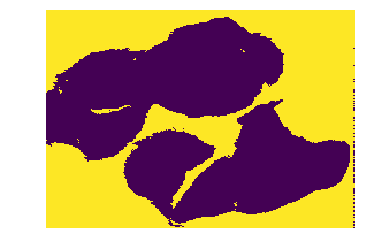

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      0.99      0.99      0.98       140
 Off sample       0.97      1.00      0.99      0.98      0.99      0.99        65

avg / total       0.99      0.99      1.00      0.99      0.99      0.99       205

497 AstraZeneca//Rat_testis
border found
matrix generated (21420, 2552)
SNR for clusters = 0.023391681571232753


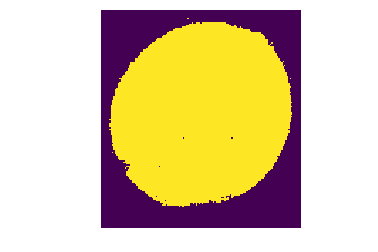

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.91      0.99      0.94      0.95      0.96      0.93       154
 Off sample       0.99      0.94      0.99      0.96      0.96      0.92       247

avg / total       0.96      0.96      0.97      0.96      0.96      0.93       401

848 ICL//7TopRight,_17BottomRight,_27BottomLeft,_37TopLeft
border found
matrix generated (19992, 500)
SNR for clusters = 0.045193717789788805


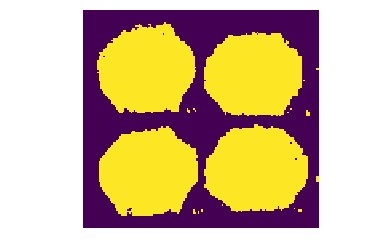

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       266
 Off sample       0.98      1.00      1.00      0.99      1.00      1.00        49

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       315

511 UoNotreDame//Untreated_6_574
border found
matrix generated (5354, 829)
SNR for clusters = 0.10738667690920634


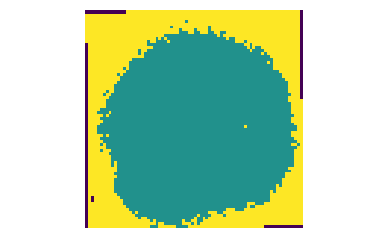

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      0.99      1.00      1.00      0.99       210
 Off sample       1.00      0.99      1.00      1.00      1.00      0.99       101

avg / total       1.00      1.00      0.99      1.00      1.00      0.99       311

290 North Carolina State University//mouse body
border found
matrix generated (32060, 7571)
SNR for clusters = 0.17717837284849886


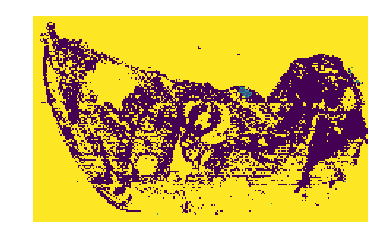

clusters found, n = 4
1 0 734 0.0 0.0
2 0 734 0.0 0.0
[4] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.98      0.92      0.99      0.95      0.95      0.90       102
 Off sample       0.94      0.99      0.92      0.96      0.95      0.91       137

avg / total       0.96      0.96      0.95      0.96      0.95      0.91       239

847 ICL//A51 CT S3-centroid
border found
matrix generated (15125, 485)
SNR for clusters = 0.13562856179747235


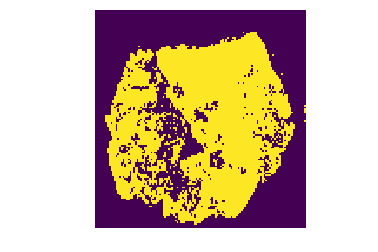

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.99      0.98      0.99      0.99      0.98       185
 Off sample       0.98      0.98      0.99      0.98      0.99      0.98        58

avg / total       0.99      0.99      0.99      0.99      0.99      0.98       243

2449 S648 WS20 205x170 20um E110
border found
matrix generated (34845, 1614)
SNR for clusters = 0.05298339044997587


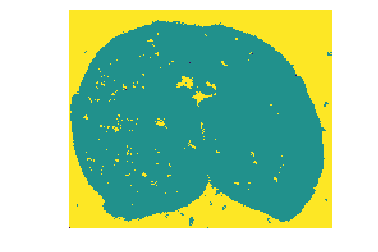

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.99      0.99      0.99      0.99      0.99       174
 Off sample       1.00      0.99      0.99      0.99      0.99      0.99       281

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       455

2448 S649 WS21 155x105 15um E110
border found
matrix generated (16275, 1304)
SNR for clusters = 0.09086167353018781


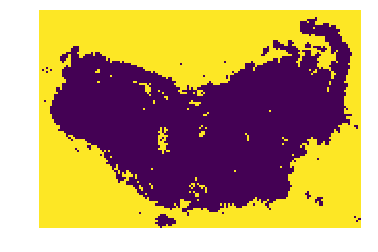

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.98      0.94      0.98      0.96      0.92       339
 Off sample       0.92      0.94      0.98      0.93      0.96      0.92        83

avg / total       0.97      0.97      0.95      0.97      0.96      0.92       422

129 MPIMM_021_QE_P_CB_0
border found
matrix generated (118162, 3818)
SNR for clusters = 0.06881361334655618


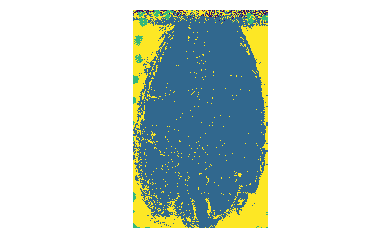

clusters found, n = 3
1 183 1467 0.12474437627811862 0.09621451104100946
[2] [1]
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.30      1.00      0.75      0.47      0.86      0.76        34
 Off sample       1.00      0.75      1.00      0.85      0.86      0.73       306

avg / total       0.93      0.77      0.97      0.82      0.86      0.73       340

47 Xenograft_3_135um
border found
matrix generated (19516, 1929)
SNR for clusters = 0.06769034477464246


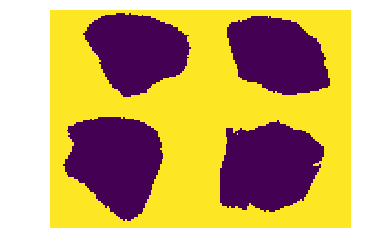

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      0.99      1.00      0.99      0.99       221
 Off sample       0.99      0.99      1.00      0.99      0.99      0.98        93

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       314

51 xenograft CT-26 S10
border found
matrix generated (54150, 4150)
SNR for clusters = 0.04455679733287983


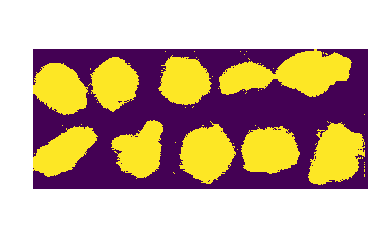

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      0.99      0.99      0.99       161
 Off sample       0.94      1.00      0.99      0.97      0.99      0.99        29

avg / total       0.99      0.99      1.00      0.99      0.99      0.99       190

75 Normal8
border found
matrix generated (2652, 308)
SNR for clusters = 0.07132975951786216


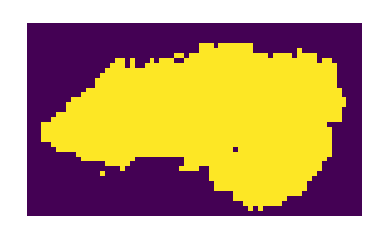

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.97      1.00      0.98      0.98      0.97       259
 Off sample       0.74      1.00      0.97      0.85      0.98      0.97        23

avg / total       0.98      0.97      1.00      0.97      0.98      0.97       282

93 Tumor11
border found
matrix generated (6160, 537)
SNR for clusters = 0.10922556382228453


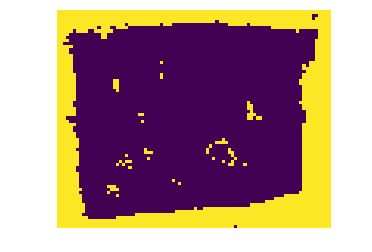

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.95      0.99      0.78      0.97      0.88      0.80       327
 Off sample       0.97      0.78      0.99      0.87      0.88      0.76        79

avg / total       0.95      0.95      0.83      0.95      0.88      0.79       406

1581 MP 39
border found
matrix generated (38282, 2405)
SNR for clusters = 0.04248512196467397


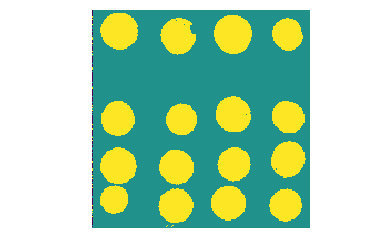

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.97      1.00      0.98      0.98      0.96       229
 Off sample       0.91      1.00      0.97      0.96      0.98      0.97        86

avg / total       0.98      0.97      0.99      0.97      0.98      0.96       315

193 DESI quan_Swales
border found
matrix generated (66928, 6376)
SNR for clusters = 0.06779825299942512


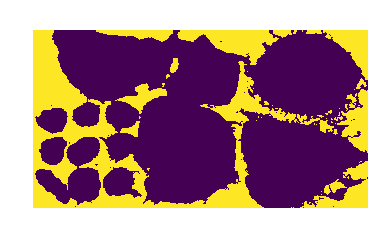

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.95      1.00      0.90      0.97      0.95      0.91       121
 Off sample       1.00      0.90      1.00      0.95      0.95      0.89        69

avg / total       0.97      0.96      0.94      0.96      0.95      0.90       190

821 ICL//LNTO22_1_3
border found
matrix generated (8228, 573)
SNR for clusters = 0.04655504009354508


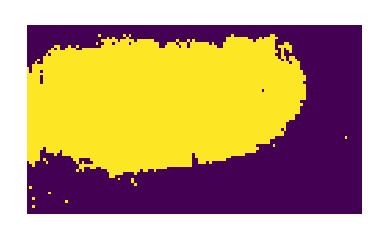

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      0.94      0.99      0.96      0.93       216
 Off sample       0.88      0.94      0.99      0.91      0.96      0.92        16

avg / total       0.99      0.99      0.94      0.99      0.96      0.93       232

935 ICL//LNTO26_7_3
border found
matrix generated (7216, 255)
SNR for clusters = 0.09329818210841034


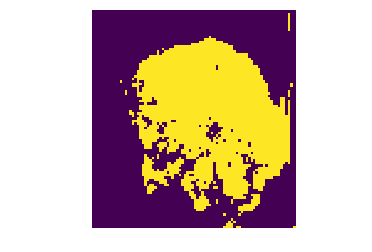

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      1.00      1.00      0.99       195
 Off sample       0.94      1.00      0.99      0.97      1.00      1.00        17

avg / total       1.00      1.00      1.00      1.00      1.00      0.99       212

835 ICL//LNTO30_16_1
border found
matrix generated (8930, 203)
SNR for clusters = 0.06414152720846286


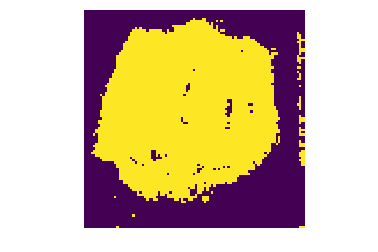

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.96      1.00      0.98      0.98      0.96        55
 Off sample       0.88      1.00      0.96      0.94      0.98      0.97        15

avg / total       0.97      0.97      0.99      0.97      0.98      0.96        70

944 ICL//LNTO31_17_4
border found
matrix generated (12216, 252)
SNR for clusters = 0.07375008384325374


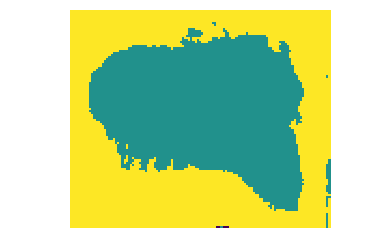

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       171
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        31

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       202

882 ICL//LNTO41_17_2
border found
matrix generated (9497, 343)
SNR for clusters = 0.08041236077005881


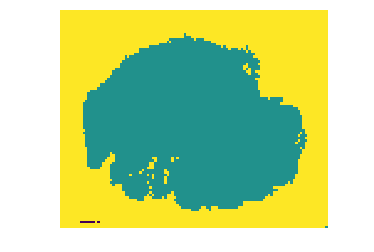

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       156
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       183

885 ICL//LNTO41_17_4
border found
matrix generated (6642, 288)
SNR for clusters = 0.10959056623865375


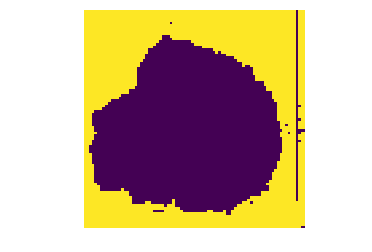

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      0.99       217
 Off sample       0.97      1.00      1.00      0.98      1.00      1.00        28

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       245

888 ICL//LNTO42_17_1
border found
matrix generated (7209, 301)
SNR for clusters = 0.0974105339741091


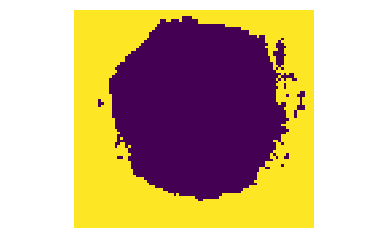

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      0.99      0.99      0.99       176
 Off sample       0.98      1.00      0.99      0.99      0.99      0.99        98

avg / total       0.99      0.99      1.00      0.99      0.99      0.99       274

53 20170105_VS_disc2_NEDC0001_70x80_10x10
border found
matrix generated (5599, 159)
SNR for clusters = 0.04331521009121233


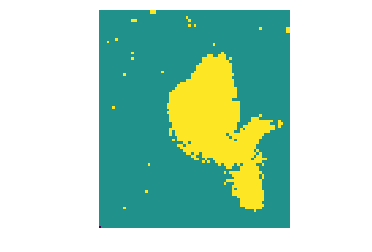

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        10
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        62

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        72

555 2017023_ADP_GFlarvae_55x55_40x40_DMAN002
border found
matrix generated (3024, 1646)
SNR for clusters = 0.10698071031477449


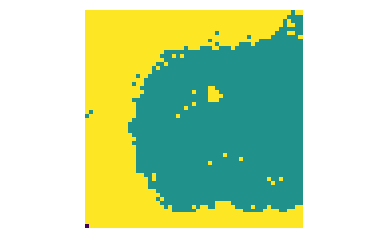

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.97      1.00      0.99      0.99      0.97        68
 Off sample       0.99      1.00      0.97      0.99      0.99      0.97       166

avg / total       0.99      0.99      0.98      0.99      0.99      0.97       234

322 Tumor17
border found
matrix generated (6760, 398)
SNR for clusters = 0.06044454473689098


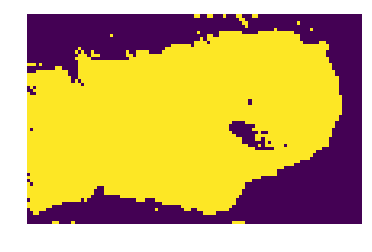

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      0.99      0.99      0.99       168
 Off sample       0.86      1.00      0.99      0.92      0.99      0.99        12

avg / total       0.99      0.99      1.00      0.99      0.99      0.99       180

190 Tumor41
border found
matrix generated (1394, 300)
SNR for clusters = 0.1346350364900516


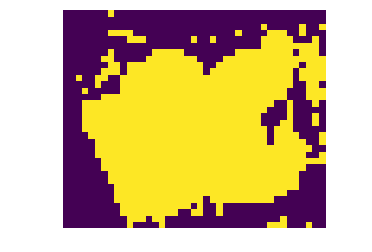

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        72
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        19

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        91

441 Borderline13
border found
matrix generated (2024, 355)
SNR for clusters = 0.14968049348111367


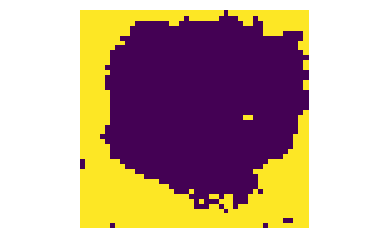

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.94      1.00      0.82      0.97      0.91      0.84       118
 Off sample       1.00      0.82      1.00      0.90      0.91      0.81        45

avg / total       0.95      0.95      0.87      0.95      0.91      0.83       163

471 Borderline14
border found
matrix generated (1575, 212)
SNR for clusters = 0.09713577949949637


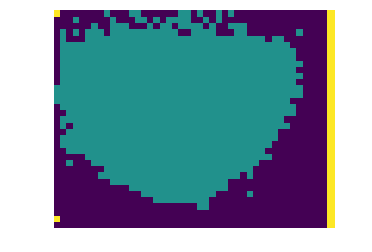

clusters found, n = 3
2 37 156 0.23717948717948717 1.0
[0] [2]
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.98      0.95      0.99      0.97      0.94       128
 Off sample       0.90      0.95      0.98      0.92      0.97      0.93        19

avg / total       0.98      0.98      0.95      0.98      0.97      0.94       147

403 Row001
border found
matrix generated (5151, 5574)
SNR for clusters = 0.050366647287907705


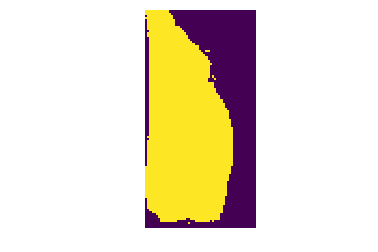

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.51      1.00      0.93      0.68      0.97      0.94        23
 Off sample       1.00      0.93      1.00      0.97      0.97      0.93       328

avg / total       0.97      0.94      1.00      0.95      0.97      0.93       351

425 MPIMM_049_QE_P_BA_CF_sp3
border found
matrix generated (32000, 493)
SNR for clusters = 0.02065317459305202


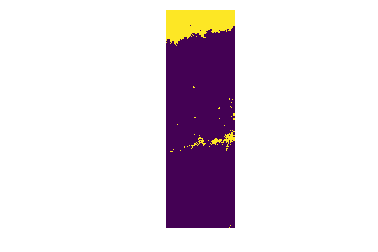

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       135
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        23

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       158

1566 161007_WT1S1L1
border found
matrix generated (12876, 2446)
SNR for clusters = 0.05772523806821517


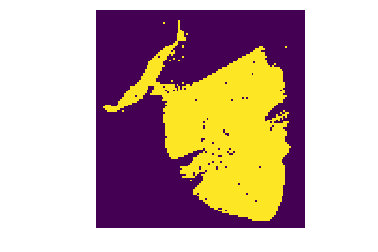

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        30
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       154

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       184

371 170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r
border found
matrix generated (3330, 981)
SNR for clusters = 0.08051981631694825


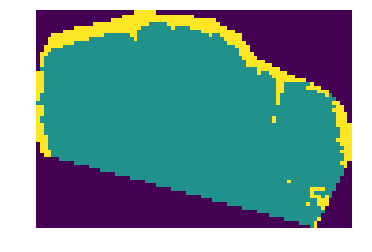

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.92      1.00      0.88      0.96      0.94      0.89       208
 Off sample       1.00      0.88      1.00      0.93      0.94      0.86       145

avg / total       0.95      0.95      0.93      0.95      0.94      0.88       353

301 NCSU_mouse_LCC6_tumor
border found
matrix generated (6439, 3347)
SNR for clusters = 0.3014498700690607
BAD IONS = 3264


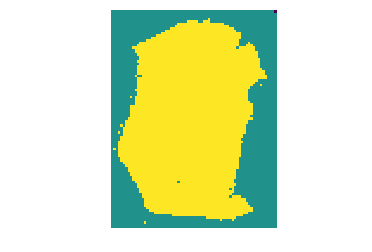

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      1.00      1.00      0.99       158
 Off sample       0.96      1.00      0.99      0.98      1.00      0.99        25

avg / total       0.99      0.99      1.00      0.99      1.00      0.99       183

566 170418_MouseBrain_pos_50um_205by129_atn0
border found
matrix generated (26444, 3749)
SNR for clusters = 0.1920143683029881


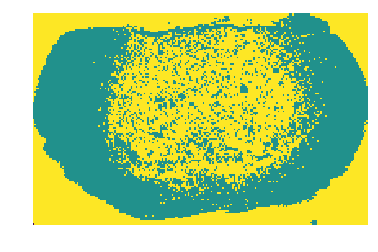

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.97      1.00      0.99      0.99      0.97       152
 Off sample       0.96      1.00      0.97      0.98      0.99      0.98       108

avg / total       0.99      0.98      0.99      0.98      0.99      0.97       260

599 NCSU_M8_mouse_brain
border found
matrix generated (7787, 3210)
SNR for clusters = 0.10689363961698901


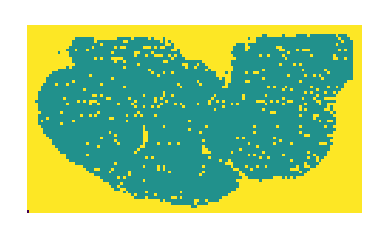

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.58      1.00      0.82      0.73      0.90      0.83        69
 Off sample       1.00      0.82      1.00      0.90      0.90      0.80       273

avg / total       0.92      0.85      0.96      0.87      0.90      0.81       342

601 20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N
border found
matrix generated (16704, 526)
SNR for clusters = 0.03254061549492081


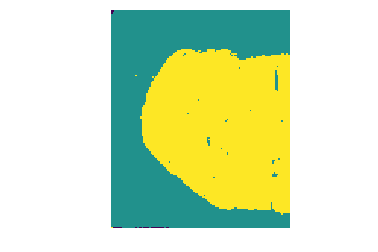

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.98      1.00      0.99      0.99      0.98       101
 Off sample       0.99      1.00      0.98      1.00      0.99      0.98       307

avg / total       1.00      1.00      0.99      1.00      0.99      0.98       408

1105 Dataset 2
border found
matrix generated (12876, 2446)
SNR for clusters = 0.05772523806821517


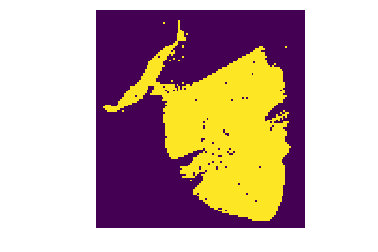

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.98      0.99      0.99      0.99      0.99      0.98       175
 Off sample       0.99      0.99      0.99      0.99      0.99      0.98       201

avg / total       0.99      0.99      0.99      0.99      0.99      0.98       376

672 Dataset 3
border found
matrix generated (11340, 2596)
SNR for clusters = 0.03731430579054533


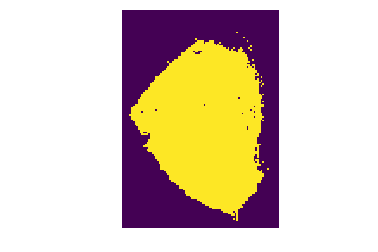

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.98      1.00      0.99      0.99      0.98       194
 Off sample       0.98      1.00      0.98      0.99      0.99      0.99       150

avg / total       0.99      0.99      0.99      0.99      0.99      0.98       344

673 Dataset 4
border found
matrix generated (11186, 2280)
SNR for clusters = 0.07107007855643065


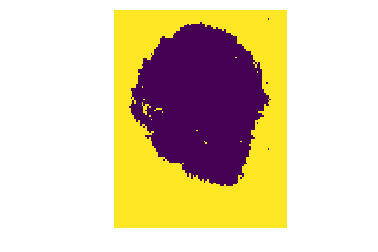

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.97      0.95      0.98      0.96      0.96      0.92       112
 Off sample       0.96      0.98      0.95      0.97      0.96      0.93       150

avg / total       0.97      0.97      0.96      0.97      0.96      0.93       262

677 Dataset 8
border found
matrix generated (13625, 6103)
SNR for clusters = 0.03813228217047686


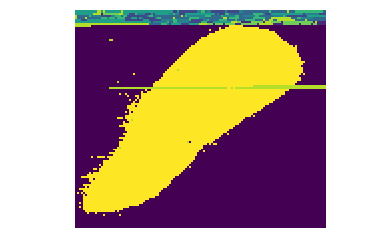

clusters found, n = 10
1 2 464 0.004310344827586207 0.06666666666666667
2 25 464 0.05387931034482758 0.21008403361344538
3 28 464 0.0603448275862069 0.16374269005847952
4 7 464 0.015086206896551725 0.0707070707070707
5 50 464 0.10775862068965517 0.2604166666666667
6 17 464 0.036637931034482756 0.17525773195876287
7 0 464 0.0 0.0
8 11 464 0.023706896551724137 0.04365079365079365
[0] [2, 3, 5, 6]
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.90      0.88      0.95      0.89      0.91      0.82        40
 Off sample       0.93      0.95      0.88      0.94      0.91      0.83        73

avg / total       0.92      0.92      0.90      0.92      0.91      0.83       113

685 Dataset 16
border found
matrix generated (11662, 2464)
SNR for clusters = 0.04493452912525232


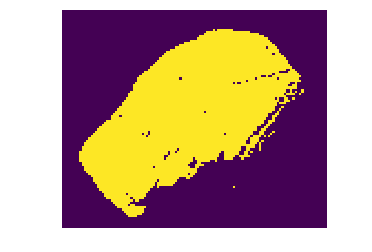

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      0.99      0.99      0.99       193
 Off sample       0.99      1.00      0.99      0.99      0.99      0.99       199

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       392

687 Dataset 18
border found
matrix generated (10556, 2902)
SNR for clusters = 0.06962990141429956


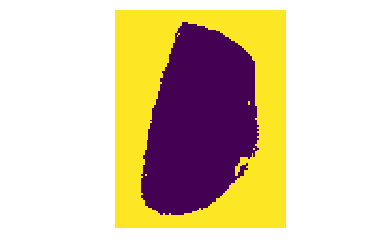

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      1.00      1.00      0.99       145
 Off sample       1.00      1.00      0.99      1.00      1.00      0.99       210

avg / total       1.00      1.00      1.00      1.00      1.00      0.99       355

690 Dataset 21
border found
matrix generated (15014, 2433)
SNR for clusters = 0.07357370492163531


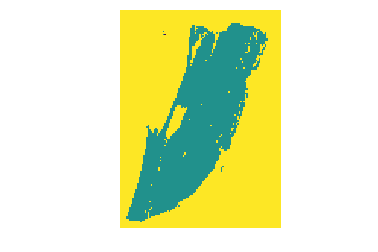

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       185
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       230

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       415

692 Dataset 23
border found
matrix generated (17262, 2850)
SNR for clusters = 0.062860123381772


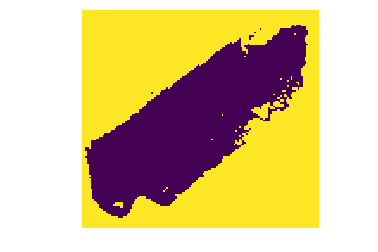

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      0.99      0.99      0.99       172
 Off sample       0.99      1.00      0.99      0.99      0.99      0.99       186

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       358

696 Dataset 27
border found
matrix generated (18630, 2564)
SNR for clusters = 0.03344559580333592


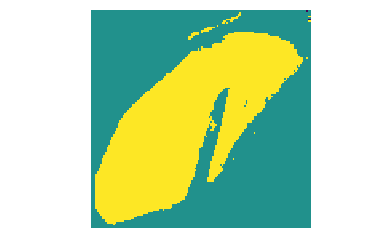

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       155
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       212

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       367

697 Servier_Ctrl_rat_liver_9aa
border found
matrix generated (49891, 694)
SNR for clusters = 0.023387392874426906


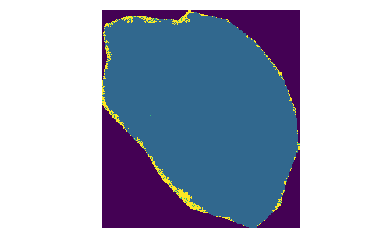

clusters found, n = 3
1 37 715 0.05174825174825175 0.21511627906976744
[2] [1]
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.97      1.00      0.83      0.99      0.91      0.85       116
 Off sample       1.00      0.83      1.00      0.91      0.91      0.82        18

avg / total       0.98      0.98      0.86      0.98      0.91      0.84       134

708 Dataset 30
border found
matrix generated (12144, 2239)
SNR for clusters = 0.03460220675413699


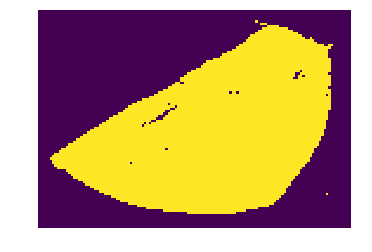

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       202
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       171

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       373

709 Dataset 31
border found
matrix generated (11600, 2233)
SNR for clusters = 0.038000093268472104


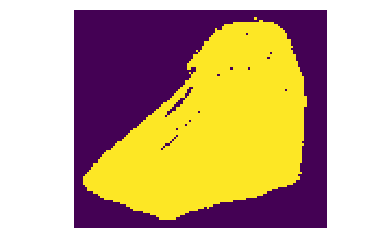

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      1.00      1.00      1.00      1.00      1.00       197
 Off sample       1.00      1.00      1.00      1.00      1.00      0.99       210

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       407

1090 CC-Esco2_centroids
border found
matrix generated (11179, 1110)
SNR for clusters = 0.09153494224401214


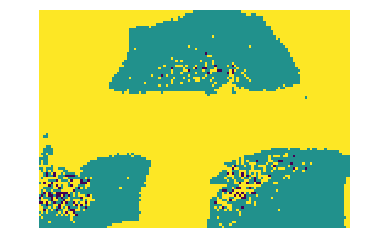

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.93      1.00      0.96      0.96      0.92        56
 Off sample       0.98      1.00      0.93      0.99      0.96      0.94       176

avg / total       0.98      0.98      0.95      0.98      0.96      0.93       232

1093 Esco1_centroids
border found
matrix generated (13680, 751)
SNR for clusters = 0.11144166964688941


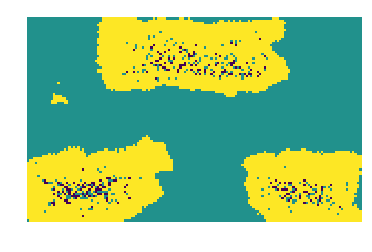

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.97      1.00      1.00      0.98      1.00      1.00        31
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       251

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       282

1094 Esco2_centroids
border found
matrix generated (14653, 805)
SNR for clusters = 0.09821042407254656


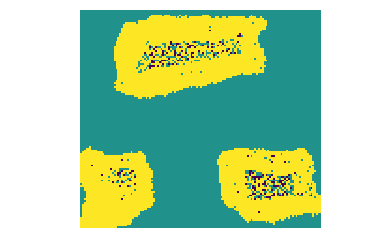

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        14
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       253

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       267

1097 ST-Pseudo_centroids
border found
matrix generated (12548, 1003)
SNR for clusters = 0.09382457362975409


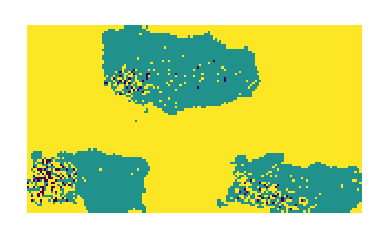

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.88      1.00      0.93      0.94      0.86        24
 Off sample       0.99      1.00      0.88      0.99      0.94      0.89       201

avg / total       0.99      0.99      0.89      0.99      0.94      0.88       225

1104 servier_TT_mouse_wb_fmpts_derivatization_CHCA
border found
matrix generated (19160, 1533)
SNR for clusters = 0.2515781904206411
BAD IONS = 962


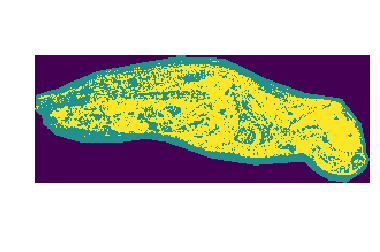

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.79      1.00      0.88      0.89      0.78       352
 Off sample       0.38      1.00      0.79      0.55      0.89      0.81        44

avg / total       0.93      0.82      0.98      0.85      0.89      0.78       396

1142 Rat51_Section2
border found
matrix generated (12665, 3533)
SNR for clusters = 0.047391172429707036


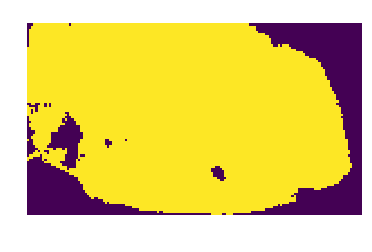

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.95      0.98      0.96      0.96      0.97      0.94        88
 Off sample       0.98      0.96      0.98      0.97      0.97      0.93       114

avg / total       0.97      0.97      0.97      0.97      0.97      0.93       202

2104 Mousebrain_MG08_2017_GruppeA
border found
matrix generated (38804, 1366)
SNR for clusters = 0.02009390571714259


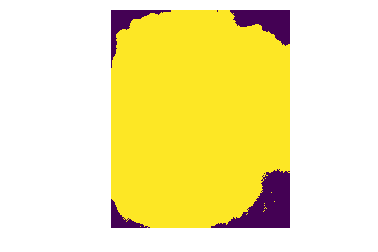

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      1.00      0.96      0.99      0.98      0.96       230
 Off sample       1.00      0.96      1.00      0.98      0.98      0.96        75

avg / total       0.99      0.99      0.97      0.99      0.98      0.96       305

1176 Dataset 3_recal
border found
matrix generated (11340, 2642)
SNR for clusters = 0.03686712168015155


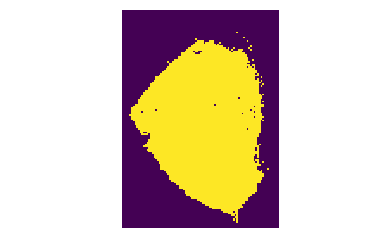

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       169
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       269

1177 Dataset 4_recal
border found
matrix generated (11186, 2311)
SNR for clusters = 0.07120285894032467


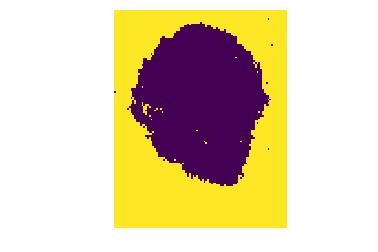

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.95      1.00      0.97      0.97      0.94       131
 Off sample       0.90      1.00      0.95      0.95      0.97      0.95        61

avg / total       0.97      0.96      0.98      0.96      0.97      0.94       192

1182 Dataset 26_recal
border found
matrix generated (18769, 2735)
SNR for clusters = 0.06517373215135057


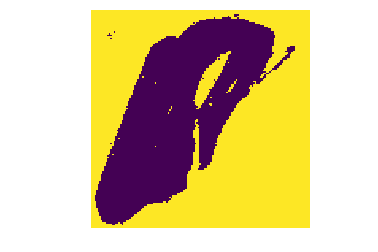

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       176
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       138

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       314

1240 slide077_animal121_rat_kidney - total ion count
border found
matrix generated (7698, 1397)
SNR for clusters = 0.054240082003627885


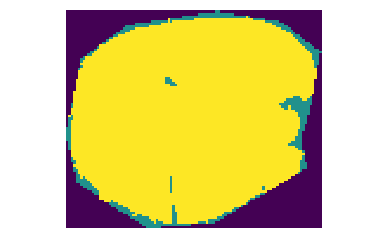

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.89      1.00      0.85      0.94      0.92      0.86       222
 Off sample       0.99      0.85      1.00      0.92      0.92      0.83       181

avg / total       0.94      0.93      0.92      0.93      0.92      0.85       403

2300 slide012_animal102_minipig_kidney- total ion count
border found
matrix generated (8156, 385)
SNR for clusters = 0.05274757219497788


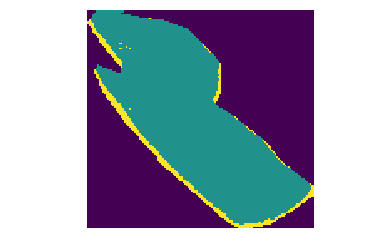

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.89      1.00      0.95      0.94      0.97      0.95        66
 Off sample       1.00      0.95      1.00      0.97      0.97      0.94       148

avg / total       0.97      0.96      0.98      0.96      0.97      0.94       214

1248 100um_noM2_001_Recal
border found
matrix generated (26995, 2718)
SNR for clusters = 0.05823165769743619


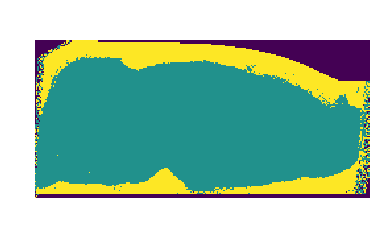

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.98      0.97      0.99      0.97      0.95       336
 Off sample       0.93      0.97      0.98      0.95      0.97      0.95        98

avg / total       0.98      0.98      0.97      0.98      0.97      0.95       434

1307 Servier_Ctrl_mouse_wb_median_plane_9aa
border found
matrix generated (36908, 128)
SNR for clusters = 0.3384950395902664
BAD IONS = 68


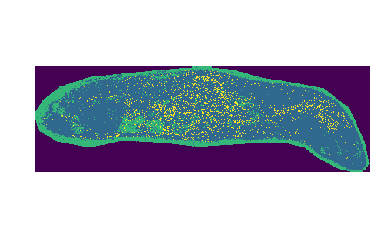

clusters found, n = 3
2 0 900 0.0 0.0
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.94      0.91      0.00      0.92      0.00      0.00       106
 Off sample       0.00      0.00      0.91      0.00      0.00      0.00         6

avg / total       0.89      0.86      0.05      0.87      0.00      0.00       112

1352 Mouse_Wholebody_3
border found
matrix generated (14099, 8560)
SNR for clusters = 0.14598120407736054


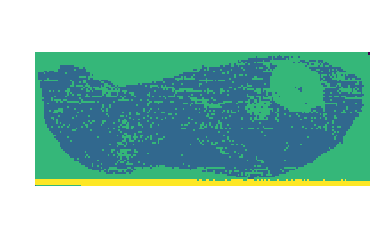

clusters found, n = 3
2 167 521 0.32053742802303264 0.25226586102719034
[1] [2]
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.93      0.99      0.96      0.96      0.91       227
 Off sample       0.90      0.99      0.93      0.94      0.96      0.92       139

avg / total       0.95      0.95      0.96      0.95      0.96      0.91       366

1394 Servier_Ctrl_mouse_wb_lateral_plane_DHB
border found
matrix generated (27719, 434)
SNR for clusters = 0.11010038272173024


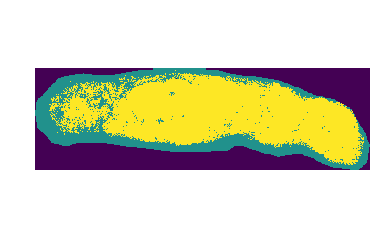

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.94      1.00      0.97      0.97      0.93       266
 Off sample       0.67      1.00      0.94      0.80      0.97      0.94        35

avg / total       0.96      0.94      0.99      0.95      0.97      0.93       301

1395 Servier_Ctrl_mouse_wb_median_plane_DHB
border found
matrix generated (37416, 422)
SNR for clusters = 0.1321928227383085


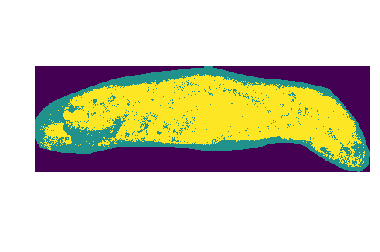

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.87      1.00      0.93      0.93      0.86       286
 Off sample       0.32      1.00      0.87      0.49      0.93      0.88        18

avg / total       0.96      0.88      0.99      0.90      0.93      0.86       304

1402 20170815_CGL_MT-M.B_DAN012_NTM_42x30_100x100
border found
matrix generated (1259, 1029)
SNR for clusters = 0.06401745809884564


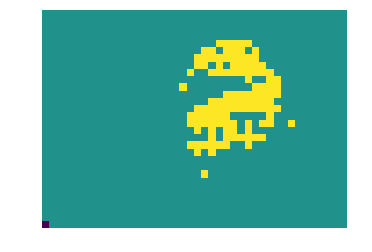

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.75      1.00      0.86      0.87      0.73        36
 Off sample       0.88      1.00      0.75      0.94      0.87      0.77        67

avg / total       0.92      0.91      0.84      0.91      0.87      0.76       103

1410 20170817_CGL_MT-M.B_ATP_DAN018_NTM_102x39_100x100
border found
matrix generated (3978, 704)
SNR for clusters = 0.07316306600826274


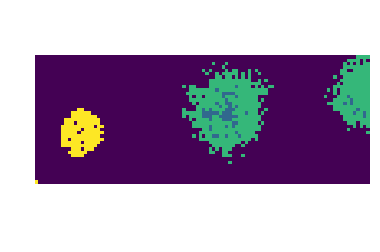

clusters found, n = 4
1 0 278 0.0 0.0
3 1 278 0.0035971223021582736 0.007407407407407408
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.99      0.99      0.99      0.99      0.98       109
 Off sample       0.99      0.99      0.99      0.99      0.99      0.98       121

avg / total       0.99      0.99      0.99      0.99      0.99      0.98       230

1435 20170905_CGL0170817_MT-MB_ATP_N_81x101_135x135
border found
matrix generated (8180, 968)
SNR for clusters = 0.22766462640892798
BAD IONS = 954


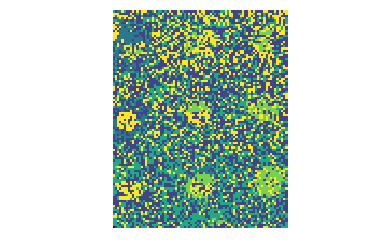

MORE valid clusters 3
clusters found, n = 5
1 13 359 0.036211699164345405 0.03735632183908046
3 2 359 0.005571030640668524 0.004357298474945534
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.95      1.00      0.97      0.97      0.94        19
 Off sample       0.98      1.00      0.95      0.99      0.97      0.95        57

avg / total       0.99      0.99      0.96      0.99      0.97      0.95        76

1439 Rat50_Section1
border found
matrix generated (45365, 1152)
SNR for clusters = 0.015232567676362087


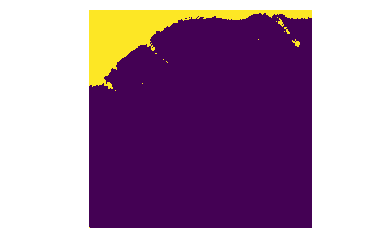

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.91      1.00      0.90      0.95      0.95      0.90       219
 Off sample       1.00      0.90      1.00      0.94      0.95      0.89       200

avg / total       0.95      0.95      0.95      0.95      0.95      0.90       419

1450 MS7_20170907_DHB_pos_MouseBrain_s3_300-1800_40um_245x134_A30-JBE-Test
border found
matrix generated (32813, 1638)
SNR for clusters = 0.04008307008651141


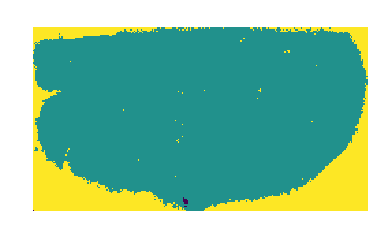

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.96      1.00      0.98      0.98      0.95       169
 Off sample       0.95      1.00      0.96      0.97      0.98      0.96       122

avg / total       0.98      0.98      0.98      0.98      0.98      0.96       291

1771 Mouse Kidney on plastic slide 260x175 30um
border found
matrix generated (45500, 2986)
SNR for clusters = 0.020863861522467497


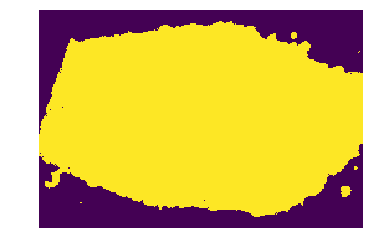

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.96      0.99      0.97      0.97      0.95       174
 Off sample       0.97      0.99      0.96      0.98      0.97      0.95       198

avg / total       0.98      0.98      0.97      0.98      0.97      0.95       372

1772 Mouse Kidney on coated plastic slide 270x160 30 um
border found
matrix generated (43200, 2342)
SNR for clusters = 0.03485009151254053


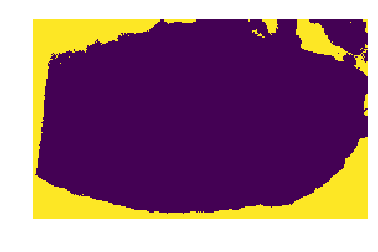

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.75      1.00      0.81      0.86      0.90      0.82       145
 Off sample       1.00      0.81      1.00      0.89      0.90      0.79       255

avg / total       0.91      0.88      0.93      0.88      0.90      0.80       400

1773 Mouse Kidney on coated plastic slide 300x165 30 um
border found
matrix generated (49500, 3781)
SNR for clusters = 0.03552073256607572


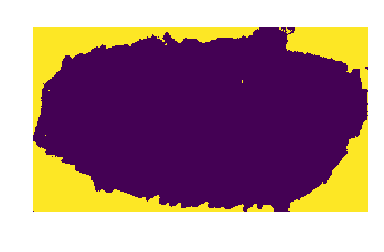

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.91      0.99      0.95      0.95      0.89       239
 Off sample       0.89      0.99      0.91      0.94      0.95      0.91       187

avg / total       0.95      0.94      0.95      0.94      0.95      0.90       426

1804 BRB04S-RECAL
border found
matrix generated (6256, 758)
SNR for clusters = 0.10215185622836083


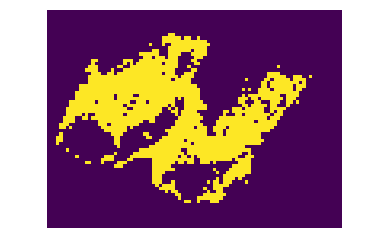

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.97      1.00      0.98      0.98      0.96       172
 Off sample       0.91      1.00      0.97      0.95      0.98      0.97        62

avg / total       0.98      0.97      0.99      0.97      0.98      0.96       234

1942 Kidney_280x140_40um_E0
border found
matrix generated (39200, 2472)
SNR for clusters = 0.03950769446100547


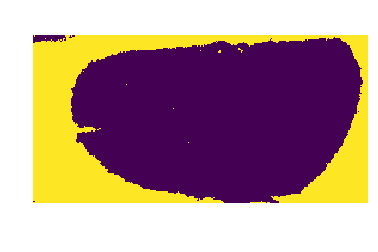

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       100
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        70

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       170

2024 LNTO31_17_1-RECAL
border found
matrix generated (6642, 264)
SNR for clusters = 0.12627672600156745


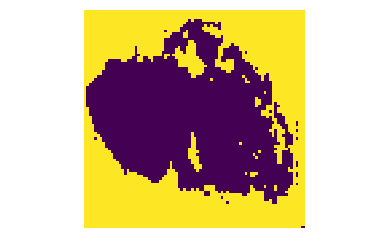

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.97      1.00      0.99      0.99      0.97       149
 Off sample       0.69      1.00      0.97      0.82      0.99      0.98         9

avg / total       0.98      0.97      1.00      0.98      0.99      0.97       158

2163 20171110_94T_RDAM_1b
border found
matrix generated (5378, 60)
SNR for clusters = 0.20344194603940208


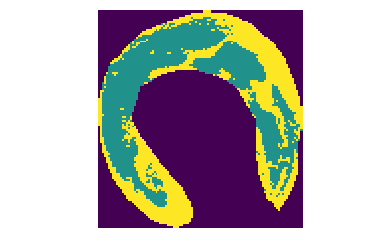

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        42
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        46

2233 DESI porcine kidney interface region
border found
matrix generated (43340, 990)
SNR for clusters = 0.0823029440160011


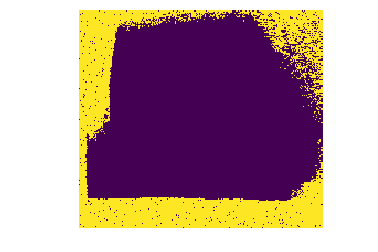

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00       469
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00         7

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       476

2291 75um_small(focusing)_high(m/z)_dry(application)
border found
matrix generated (1032, 103)
SNR for clusters = 0.09690513241706385


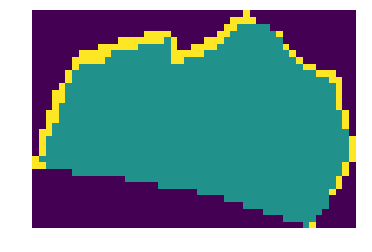

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.74      1.00      0.69      0.85      0.83      0.71        46
 Off sample       1.00      0.69      1.00      0.81      0.83      0.66        51

avg / total       0.88      0.84      0.85      0.83      0.83      0.69        97

2293 75um_small(focusing)_low(m/z)_dry(application)
border found
matrix generated (887, 36)
SNR for clusters = 0.07791048671679618


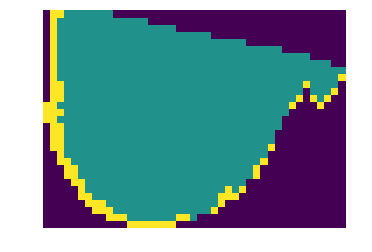

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.33      1.00      0.64      0.50      0.80      0.67         5
 Off sample       1.00      0.64      1.00      0.78      0.80      0.62        28

avg / total       0.90      0.70      0.95      0.74      0.80      0.63        33

2297 50um_min(focusing)_high(m/z)_dry(application)
border found
matrix generated (2102, 13)
SNR for clusters = 0.09802750897676611


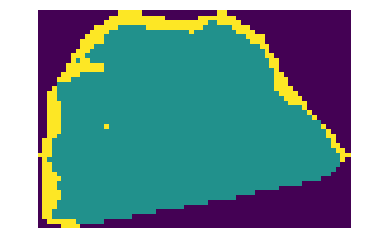

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00         1
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        10

2313 12_cylces_75um_new_submission
border found
matrix generated (2113, 653)
SNR for clusters = 0.08369172760698815


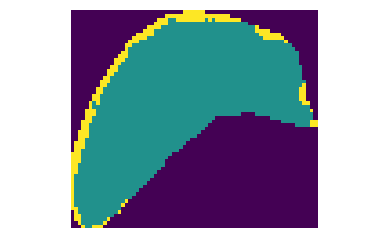

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.95      1.00      0.91      0.97      0.95      0.92       212
 Off sample       1.00      0.91      1.00      0.95      0.95      0.90       123

avg / total       0.97      0.97      0.94      0.97      0.95      0.91       335

2329 50%meoh_8cyc_75um
border found
matrix generated (1712, 573)
SNR for clusters = 0.08073557248248031


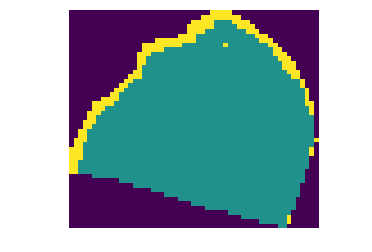

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.97      1.00      0.97      0.99      0.98      0.97       186
 Off sample       1.00      0.97      1.00      0.98      0.98      0.96       152

avg / total       0.99      0.99      0.98      0.99      0.98      0.97       338

2330 70%meoh_8cyc_75um
border found
matrix generated (1743, 588)
SNR for clusters = 0.09851094748378937


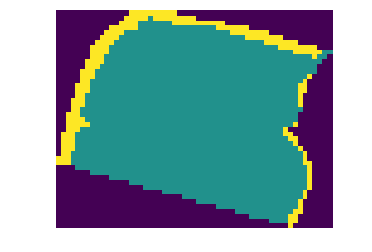

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        38
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00       165

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       203

2336 20180220_mouse eye_DHB
border found
matrix generated (8464, 986)
SNR for clusters = 0.043464472709644986


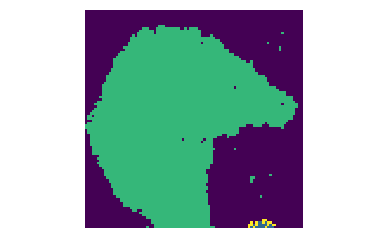

clusters found, n = 4
1 8 364 0.02197802197802198 0.47058823529411764
3 3 364 0.008241758241758242 0.1875
[0] [1, 3]
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.97      0.86      0.95      0.92      0.90      0.81       258
 Off sample       0.75      0.95      0.86      0.84      0.90      0.83       113

avg / total       0.91      0.89      0.92      0.89      0.90      0.82       371

98 HK_S2_N2_20um_New
border found
matrix generated (21216, 1260)
SNR for clusters = 0.047640087959250746


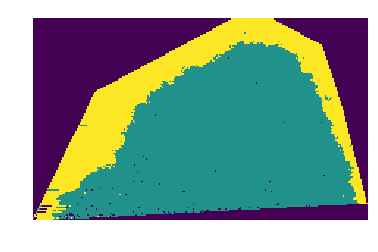

clusters found, n = 2
[1] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      0.99      1.00      1.00      1.00      0.99       236
 Off sample       0.99      1.00      0.99      0.99      1.00      0.99       184

avg / total       1.00      1.00      1.00      1.00      1.00      0.99       420

94 PS_7_P7_N1_30um_New
border found
matrix generated (22316, 208)
SNR for clusters = 0.08402572629250717


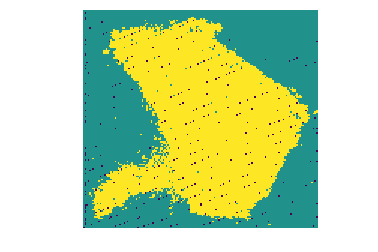

clusters found, n = 2
[0] []
                   pre       rec       spe        f1       geo       iba       sup

  On sample       1.00      1.00      1.00      1.00      1.00      1.00        91
 Off sample       1.00      1.00      1.00      1.00      1.00      1.00        53

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       144

F1 ON average with 87 batches: 0.96 (+/- 0.18)
P ON average: 0.95 (+/- 0.25)
R ON average: 0.97 (+/- 0.09)

F1 OFF with 87 batches: 0.94 (+/- 0.26)
P OFF average: 0.94 (+/- 0.30)
R OF average: 0.95 (+/- 0.25)


In [16]:
from scipy.sparse import csr_matrix

f1_off = []
f1_on = []
p_off = []
p_on = []
r_off = []
r_on = []

swap_clusters = ['MPIMM_049_QE_P_BA_CF_sp3', 'Rat50_Section1']

result = pd.DataFrame(columns=['ds_ind', 'datasetId', 'ion_ind', 'prediction', 'gs'])

for datasetId, ds_rows in gs_df.groupby('datasetId'):
    ds_row = ds_df[ds_df['id'] == datasetId]
        
    if len(ds_row.index)==0: 
        print('Dataset not found: ', datasetId)
        continue
        
    ds_name = ds_row['name'].iloc[0]
    ds_ind = ds_row.index.tolist()[0]         
            
    print(ds_ind, ds_name)
    
    pixel_df_path = path.join(ann_path, '{}'.format(ds_ind))
    pixel_df = pd.read_msgpack(pixel_df_path)
    pixel_df = pixel_df[pixel_df.fdr <= 50]
                   
    coord_df = pixel_df[['x', 'y']].drop_duplicates()[['x', 'y']]  
    border_df = find_border_pixels(coord_df)
    coord_df = coord_df.merge(border_df, on=['x', 'y'], how='left')
    print('border found')
        
    gs_inds_on = get_ion_ind_df(ds_rows[ds_rows.type == 'on'])
    gs_inds_off = get_ion_ind_df(ds_rows[ds_rows.type == 'off'])
    y_test = [0] * len(gs_inds_on) + [1] * len(gs_inds_off)
    
    (good_clusters, ion_clusters) = cluster_classification(pixel_df, coord_df, gs_inds_on + gs_inds_off)
    
    prediction = ion_clusters
    
    #EVALUATE
    loc_result = pd.DataFrame({'ds_name': [ds_name]*len(ion_clusters),
                              'ds_ind': [ds_ind]*len(ion_clusters),
                              'datasetId': [datasetId]*len(ion_clusters),
                              'ion_ind': gs_inds_on+gs_inds_off,
                             'prediction': prediction,
                             'gs': y_test})
    result = result.append(loc_result)

    
    f1_off.append(f1_score(y_test, prediction, pos_label = 1))
    f1_on.append(f1_score(y_test, prediction, pos_label = 0))
        
    p_off.append(precision_score(y_test, prediction, pos_label = 1))
    p_on.append(precision_score(y_test, prediction, pos_label = 0))
        
    r_off.append(recall_score(y_test, prediction, pos_label = 1))
    r_on.append(recall_score(y_test, prediction, pos_label = 0))
    
    print(classification_report_imbalanced(y_test, prediction, target_names=['On sample', 'Off sample']))

print("F1 ON average with %d batches: %0.2f (+/- %0.2f)" % (len(f1_on), np.mean(f1_on), np.std(f1_on) * 2))
print("P ON average: %0.2f (+/- %0.2f)" % (np.mean(p_on), np.std(p_on) * 2))
print("R ON average: %0.2f (+/- %0.2f)" % (np.mean(r_on), np.std(r_on) * 2))

print()

print("F1 OFF with %d batches: %0.2f (+/- %0.2f)" % (len(f1_off), np.mean(f1_off), np.std(f1_off) * 2))
print("P OFF average: %0.2f (+/- %0.2f)" % (np.mean(p_off), np.std(p_off) * 2))
print("R OF average: %0.2f (+/- %0.2f)" % (np.mean(r_off), np.std(r_off) * 2))

In [196]:
# Predefined folds to compare all models
vitaly_folds = [['DESI porcine kidney interface region',
  '20180220_mouse eye_DHB',
  'Servier_Ctrl_mouse_wb_median_plane_DHB',
  'slide012_animal102_minipig_kidney- total ion count',
  'Dataset 31',
  'xenograft CT-26 S10',
  'Dataset 26_recal',
  '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r',
  'Servier_Ctrl_mouse_wb_median_plane_9aa',
  'LNTO31_17_1-RECAL',
  '2017023_ADP_GFlarvae_55x55_40x40_DMAN002',
  '161007_WT1S1L1',
  'servier_TT_mouse_wb_fmpts_derivatization_CHCA',
  'ICL//LNTO30_16_1',
  'ICL//LNTO42_17_1',
  'ICL//LNTO41_17_4',
  '50%meoh_8cyc_75um'],
 ['Esco2_centroids',
  '20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
  'Dataset 23',
  'Dataset 4',
  'Mouse Kidney on plastic slide 260x175 30um',
  '20170815_CGL_MT-M.B_DAN012_NTM_42x30_100x100',
  'S648 WS20 205x170 20um E110',
  'MP 39',
  '50um_min(focusing)_high(m_z)_dry(application)',
  '20170817_CGL_MT-M.B_ATP_DAN018_NTM_102x39_100x100',
  'UoNotreDame//Untreated_6_574',
  'NCSU_mouse_LCC6_tumor',
  'AstraZeneca//CT26_xenograft',
  'MPIMM_049_QE_P_BA_CF_sp3',
  'Dataset 4_recal',
  'Mouse Kidney on coated plastic slide 270x160 30 um',
  'NCSU_M8_mouse_brain',
  '20170905_CGL0170817_MT-MB_ATP_N_81x101_135x135'],
 ['Servier_Ctrl_mouse_wb_lateral_plane_DHB',
  'AstraZeneca//Rat_testis',
  'Dataset 30',
  '100um_noM2_001_Recal',
  'Row001',
  '20171110_94T_RDAM_1b',
  'Servier_Ctrl_rat_liver_9aa',
  'PS_7_P7_N1_30um_New',
  'Dataset 27',
  'BRB04S-RECAL',
  'Dataset 21',
  'ICL//LNTO41_17_2',
  'Esco1_centroids',
  '75um_small(focusing)_low(m_z)_dry(application)',
  'DESI quan_Swales',
  'Xenograft_3_135um',
  'ST-Pseudo_centroids',
  'North Carolina State University//mouse body'],
 ['Dataset 18',
  'ICL//A51 CT S3-centroid',
  'Dataset 16',
  'Borderline14',
  'Rat50_Section1',
  'Tumor17',
  'ICL//LNTO22_1_3',
  'ICL//7TopRight,_17BottomRight,_27BottomLeft,_37TopLeft',
  'MPIMM_021_QE_P_CB_0',
  '20170105_VS_disc2_NEDC0001_70x80_10x10',
  'slide077_animal121_rat_kidney - total ion count',
  'Normal8',
  'ICL//LNTO31_17_4',
  'Dataset 8',
  'Mousebrain_MG08_2017_GruppeA',
  'ICL//LNTO26_7_3',
  'Mouse Kidney on coated plastic slide 300x165 30 um'],
 ['Dataset 3',
  'Mouse_Wholebody_3',
  'Rat51_Section2',
  '12_cylces_75um_new_submission',
  'CC-Esco2_centroids',
  'Dataset 2',
  'Tumor11',
  '70%meoh_8cyc_75um',
  '170418_MouseBrain_pos_50um_205by129_atn0',
  'Borderline13',
  'Kidney_280x140_40um_E0',
  'S649 WS21 155x105 15um E110',
  'MS7_20170907_DHB_pos_MouseBrain_s3_300-1800_40um_245x134_A30-JBE-Test',
  'Tumor41',
  'HK_S2_N2_20um_New',
  '75um_small(focusing)_high(m_z)_dry(application)',
  'Dataset 3_recal']]

folds = []
diff_inds = result.ds_ind.unique()
for ds_names in vitaly_folds:
    ds_inds = []
    for dn in ds_names:
        dn = dn.replace('__','//')
        dn = dn.replace('m_z', 'm/z')
        inds = ds_df[ds_df["name"] == dn].index.tolist()
        if len(inds) > 1: 
            ds_inds.append([i for i in inds if i in diff_inds][0])
        else: ds_inds.append(inds[0])
    if len(ds_names) != len(ds_inds): print('problem!')
    folds.append(ds_inds)

In [197]:
f1_off = []
f1_on = []
p_off = []
p_on = []
r_off = []
r_on = []

result['prediction'] = result['prediction'].astype(int)

for i, batch in enumerate(folds):
    print('FOLD', i)
    
    ds_res_df = result[result['ds_ind'].isin(batch)]
    
    gs = ds_res_df['gs'].values.tolist()
    prediction = ds_res_df['prediction'].values.tolist()
    
    f1_off.append(f1_score(gs, prediction, pos_label = 1))
    f1_on.append(f1_score(gs, prediction, pos_label = 0))
        
    p_off.append(precision_score(gs, prediction, pos_label = 1))
    p_on.append(precision_score(gs, prediction, pos_label = 0))
        
    r_off.append(recall_score(gs, prediction, pos_label = 1))
    r_on.append(recall_score(gs, prediction, pos_label = 0))
    
    print(classification_report_imbalanced(gs, prediction, target_names=['On sample', 'Off sample']))

print("F1 ON average with %d batches: %0.2f (+/- %0.2f)" % (len(f1_on), np.mean(f1_on), np.std(f1_on) * 2))
print("P ON average: %0.2f (+/- %0.2f)" % (np.mean(p_on), np.std(p_on) * 2))
print("R ON average: %0.2f (+/- %0.2f)" % (np.mean(r_on), np.std(r_on) * 2))

print()

print("F1 OFF with %d batches: %0.2f (+/- %0.2f)" % (len(f1_off), np.mean(f1_off), np.std(f1_off) * 2))
print("P OFF average: %0.2f (+/- %0.2f)" % (np.mean(p_off), np.std(p_off) * 2))
print("R OF average: %0.2f (+/- %0.2f)" % (np.mean(r_off), np.std(r_off) * 2))

FOLD 0
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.99      0.89      0.97      0.94      0.93      0.86      3160
 Off sample       0.81      0.97      0.89      0.88      0.93      0.87      1480

avg / total       0.93      0.92      0.95      0.92      0.93      0.87      4640

FOLD 1
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.95      0.98      0.96      0.96      0.97      0.94      2129
 Off sample       0.98      0.96      0.98      0.97      0.97      0.93      2518

avg / total       0.97      0.97      0.97      0.97      0.97      0.93      4647

FOLD 2
                   pre       rec       spe        f1       geo       iba       sup

  On sample       0.97      0.98      0.97      0.98      0.98      0.95      2402
 Off sample       0.98      0.97      0.98      0.98      0.98      0.95      2264

avg / total       0.98      0.98      0.98      0.98      